# Init

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [11]:
import pandas as pd
pd.options.display.max_rows=250
pd.options.display.max_columns=30
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import seaborn as sns; sns.set()

import pyspark.sql.functions as func

# Dataset Imports

In [3]:
start = datetime.now()

df_mentions = spark.read.parquet("s3://labadie-gdelt-tradewar/filtered_mentions.parquet")
df_mentions.cache()

print(df_mentions.count())
print(df_mentions.printSchema())
print(datetime.now()-start)

221817927
root
 |-- EventDate: string (nullable = true)
 |-- MentionSource: string (nullable = true)
 |-- MentionIdentifier: string (nullable = true)
 |-- MentionDocTone: float (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)

None
0:01:56.694992


# Model

### Create Features

In [37]:
start = datetime.now()

df_all=df_mentions.groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(all)"),
                                                  func.count("MentionDocTone").alias("count(all)"))

df_trump=df_mentions.where(df_mentions.MentionIdentifier.rlike('trump')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(trump)"),
                                 func.count("MentionDocTone").alias("count(trump)"))

df_trump_candidate=df_mentions.where((df_mentions.MentionIdentifier.rlike('trump')) & 
                           (df_mentions.Month<201603)). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(trump_cand)"),
                                 func.count("MentionDocTone").alias("count(trump_cand)"))

df_trump_president=df_mentions.where((df_mentions.MentionIdentifier.rlike('trump')) & 
                           (df_mentions.Year>=2017)). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(trump_pres)"),
                                 func.count("MentionDocTone").alias("count(trump_pres)"))

df_president_trump=df_mentions.where((df_mentions.MentionIdentifier.rlike('president')) & 
                           (df_mentions.Year>=2017)). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(president_trump)"),
                                 func.count("MentionDocTone").alias("count(president_trump)"))

df_president_trump=df_mentions.where((df_mentions.MentionIdentifier.rlike('president')) & 
                           (df_mentions.Year<2017)). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(president_obama)"),
                                 func.count("MentionDocTone").alias("count(president_obama)"))

df_obama=df_mentions.where(df_mentions.MentionIdentifier.rlike('obama')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(obama)"),
                                 func.count("MentionDocTone").alias("count(obama)"))

df_clinton=df_mentions.where(df_mentions.MentionIdentifier.rlike('clinton')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(clinton)"),
                                 func.count("MentionDocTone").alias("count(clinton)"))

df_charlottesville=df_mentions.where(df_mentions.MentionIdentifier.rlike('charlottesville')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(charlottesville)"),
                                 func.count("MentionDocTone").alias("count(charlottesville)"))

df_anthem=df_mentions.where(df_mentions.MentionIdentifier.rlike('anthem')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(anthem)"),
                                 func.count("MentionDocTone").alias("count(anthem)"))

df_inauguration=df_mentions.where(df_mentions.MentionIdentifier.rlike('inauguration')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(inauguration)"),
                                 func.count("MentionDocTone").alias("count(inauguration)"))

df_mueller=df_mentions.where(df_mentions.MentionIdentifier.rlike('mueller')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(mueller)"),
                                 func.count("MentionDocTone").alias("count(mueller)"))

df_tariff=df_mentions.where(df_mentions.MentionIdentifier.rlike('tariff')). \
    groupby("MentionSource").agg(func.mean("MentionDocTone").alias("tone(tariff)"),
                                 func.count("MentionDocTone").alias("count(tariff)"))


df=df_all.join(df_trump,["MentionSource"],how="left") \
        .join(df_trump_president,["MentionSource"],how="left") \
        .join(df_trump_candidate,["MentionSource"],how="left") \
        .join(df_obama,["MentionSource"],how="left") \
        .join(df_clinton,["MentionSource"],how="left") \
        .join(df_charlottesville,["MentionSource"],how="left") \
        .join(df_anthem,["MentionSource"],how="left") \
        .join(df_inauguration,["MentionSource"],how="left") \
        .join(df_mueller,["MentionSource"],how="left") \
        .join(df_tariff,["MentionSource"],how="left") 

df.cache()
df.count()

print(datetime.now()-start)

pd_df = pd.DataFrame(df.collect(),columns=df.columns)
pd_df2 = pd_df.dropna()

0:00:17.495484


### List of Notables

In [57]:
notables=["nytimes.com","washingtonpost.com","cnn.com","reuters.com",#"ap.org",
          "cbsnews.com","aljazeera.com","wsj.com","huffingtonpost.com","slate.com",
          "usatoday.com","latimes.com","chron.com","chicagotribune.com","tampabay.com",
          "theguardian.com","foxnews.com","rt.com","thehill.com",#"dailymail.co.uk",
          "breitbart.com","politico.com","nypost.com","bbc.co.uk",#"nationalenquirer.com",
          "infowars.com","newsmax.com","salon.com","theblaze.com",#"dailykos.com",
          "vox.com","foxbusiness.com","cnbc.com","bloomberg.com","npr.org"]

In [51]:
pd_df[pd_df["MentionSource"].isin(notables)].sort_values(by=["tone(all)"])

,MentionSource,tone(all),count(all),tone(trump),count(trump),tone(trump_pres),count(trump_pres),tone(trump_cand),count(trump_cand),tone(obama),count(obama),tone(clinton),count(clinton),tone(charlottesville),count(charlottesville),tone(anthem),count(anthem),tone(inauguration),count(inauguration),tone(mueller),count(mueller),tone(tariff),count(tariff)
270,aljazeera.com,-4.588505,121208,-3.012832,7264.0,-3.099002,6010.0,-2.870898,307.0,-2.875576,1400.0,-1.764331,523.0,-6.869821,95.0,-3.942593,7.0,-2.473984,43.0,-3.409647,127.0,-3.021344,102.0
5342,chron.com,-4.415469,859909,-1.869325,564.0,-2.164635,317.0,-2.667910,59.0,-1.956859,39.0,0.123621,92.0,-1.894195,6.0,-2.216914,15.0,-1.675484,98.0,-6.018518,5.0,-3.116274,774.0
2873,foxnews.com,-4.217948,554751,-2.520335,66960.0,-2.664183,50650.0,-2.246053,3435.0,-2.528910,14499.0,-2.041781,12057.0,-7.492365,444.0,-0.551926,75.0,-2.374137,445.0,-4.030993,3470.0,-1.827992,311.0
4664,rt.com,-4.011625,112107,-2.894144,5667.0,-3.082667,4145.0,-2.353735,182.0,-2.729952,1617.0,-2.268549,1010.0,-6.056902,30.0,-2.465905,13.0,-3.629276,27.0,-3.272725,48.0,-3.677736,80.0
4693,nypost.com,-3.952197,155786,-2.448419,17169.0,-2.574348,13217.0,-2.524253,666.0,-2.544829,3119.0,-1.802885,1920.0,-7.914298,119.0,-2.332940,32.0,-1.483197,158.0,-3.506811,667.0,-2.728449,202.0
4516,infowars.com,-3.826790,18483,-3.077585,4710.0,-2.993921,4198.0,-2.705361,4.0,-2.645369,488.0,-3.147615,545.0,-5.603679,7.0,-2.660651,12.0,-1.019584,6.0,-3.730170,249.0,-3.139868,62.0
3458,cbsnews.com,-3.717375,183077,-1.998035,24699.0,-2.118603,17870.0,-1.435998,1464.0,-1.572651,4326.0,-1.145310,3907.0,-6.470958,287.0,-0.850647,53.0,-1.132332,158.0,-2.589342,791.0,-2.876631,551.0
2240,salon.com,-3.586166,189370,-2.521692,31469.0,-2.647531,19362.0,-2.466136,2455.0,-2.179448,5579.0,-1.633119,4644.0,-4.838743,140.0,-0.940501,30.0,-1.743388,253.0,-2.813589,938.0,-1.891267,96.0
2636,bbc.co.uk,-3.554097,299163,-3.460272,542.0,-3.775421,489.0,-3.984130,3.0,-0.526105,43.0,0.638435,19.0,-18.212448,8.0,-4.615385,2.0,-0.412993,3.0,-5.059524,2.0,-2.690438,6.0
1131,washingtonpost.com,-3.467356,954479,-2.129291,127859.0,-2.223869,94990.0,-1.908839,5712.0,-1.715168,18959.0,-1.262819,17349.0,-5.350614,1208.0,0.380519,113.0,-2.191010,940.0,-3.162203,3033.0,-2.715498,1879.0


### K-means Model
I imagine, now that the data is a manageable size, that this analysis could just be done locally.  But I'll be using Spark's clustering capabilities.

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import pyspark.ml.feature as feat
from pyspark.ml.evaluation import ClusteringEvaluator
import re

# handle NA records
dataset=df.dropna() #dataset=df.na.fill(0)
dataset=dataset.where(dataset.MentionSource.isin(notables))

# convert counts to percentage of total
cols = dataset.columns
regex = re.compile("^(?!count.*(all))count.*")
count_cols=list(filter(regex.search,cols))
for x in count_cols:
    dataset=dataset.withColumn(x,(func.col(x)/func.col("count(all)")))

# build features vector
cols_to_use=[a for a in dataset.columns[1:] if not re.search('count.*all', a)]
vectorAssembler = feat.VectorAssembler(
    inputCols=cols_to_use
    , outputCol='features')

# standardize features
std_scaler = feat.StandardScaler(inputCol=vectorAssembler.getOutputCol(), outputCol="scaledFeatures", withStd=True, withMean=True)

# Trains a k-means model.
#kmeans = KMeans(featuresCol='scaledFeatures').setK(3).setSeed(1)
kmeans = KMeans().setK(3).setSeed(1)

pipeline = Pipeline(stages=[vectorAssembler, kmeans]) #, std_scaler
model = pipeline.fit(dataset)

# Make predictions
predictions = model.transform(dataset)
predictions = predictions.drop('features')
predictions = predictions.drop('unscaledfeatures')

print()
print("Prediction Categories")
pd_transformed = pd.DataFrame(predictions.collect(),columns=predictions.columns)
pd_transformed.to_csv("notables.csv",sep="|",index=False)
print(pd_transformed["prediction"].value_counts())


Prediction Categories
0    19
2    11
1     1
Name: prediction, dtype: int64


# Analysis of Results

In [63]:
pd_transformed[["MentionSource","prediction"]].sort_values(by=["prediction","MentionSource"])

,MentionSource,prediction
6,bloomberg.com,0
18,cbsnews.com,0
20,chicagotribune.com,0
29,chron.com,0
30,cnbc.com,0
14,cnn.com,0
12,foxbusiness.com,0
16,huffingtonpost.com,0
5,newsmax.com,0
19,npr.org,0


['tone(all)', 'tone(trump)', 'tone(trump_pres)', 'tone(trump_cand)', 'tone(obama)', 'tone(clinton)', 'tone(charlottesville)', 'tone(anthem)', 'tone(inauguration)', 'tone(mueller)', 'tone(tariff)']


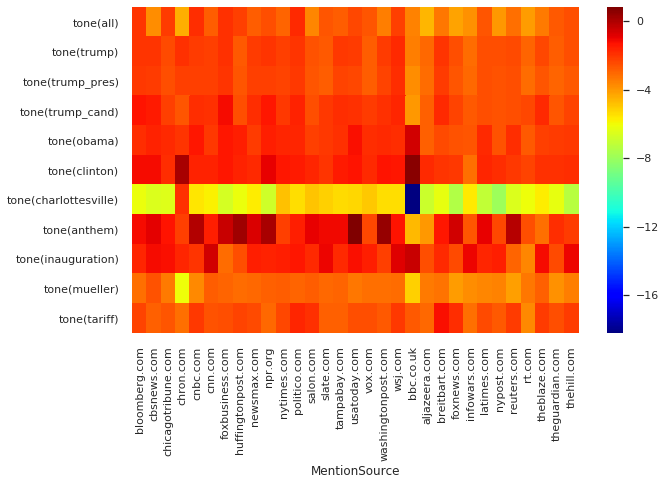

In [64]:
temp=pd_transformed.sort_values(by=["prediction","MentionSource"]).drop("prediction",axis=1).drop("count(all)",axis=1).set_index("MentionSource")

cols = temp.columns
regex = re.compile("tone.*")
tone_cols=list(filter(regex.search,cols))
print(tone_cols)

fig, ax = plt.subplots(figsize=(10,6)) 

sns.heatmap(temp[tone_cols].T,ax=ax, cmap="jet")